# [Computational Social Science] Project 4: Unsupervised Learning

**Sofia Guo**

With help from: Stacy Chen, Reiley Reed

*Semester:* Fall 2023

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split

2023-12-15 07:49:36.040548: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-15 07:49:36.174853: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-15 07:49:36.179132: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-15 07:49:36.179151: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

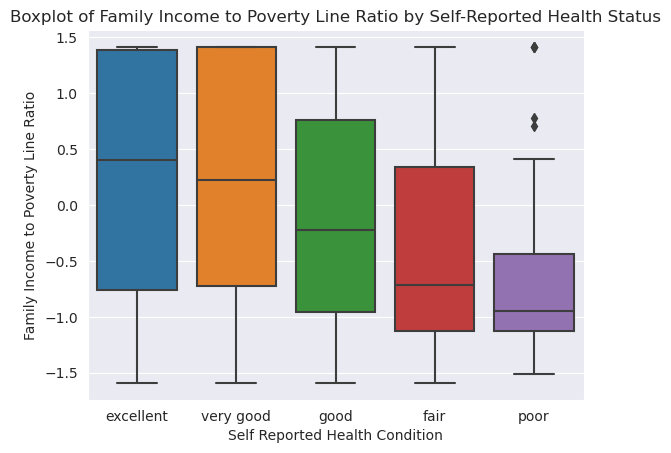

In [3]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

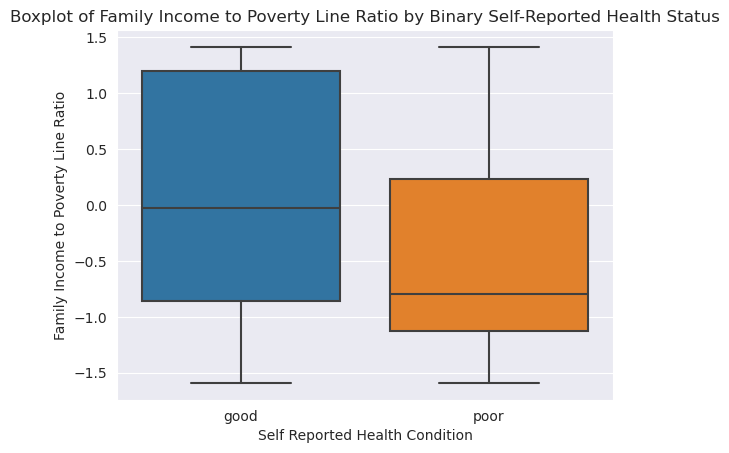

In [4]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

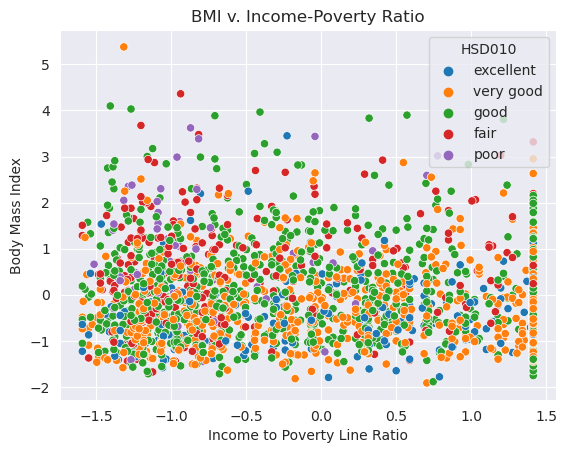

In [5]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [6]:
X = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components. 
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model. 
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

**I will choose to test three components first to see what percent of the total variance they explain in my dataset. Three is probably a reasonable guess based on the activity in the PCA lab, and that these data in particular have a lot of correlated variables (so the number of strong PCA components should be less).**

### Train PCA and Discuss Number of Components

In [7]:
# load library 
# ----------
from sklearn.decomposition import PCA

# apply PCA
# ----------
pca = PCA(n_components=3)
principalComponents_nhanes = pca.fit_transform(X)

In [8]:
# convert into a dataframe
# ----------
pca_df = pd.DataFrame(data = principalComponents_nhanes, 
                      columns = ['principal component 1', 
                                 'principal component 2',
                                'principal component 3'])

### Barplot of Components

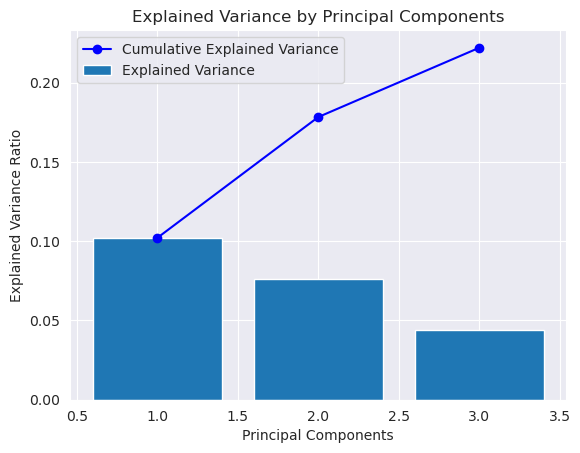

In [9]:
# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Barplot of the explained variance for each component
plt.bar(range(1, len(cumulative_explained_variance) + 1), pca.explained_variance_ratio_, label='Explained Variance')
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, label='Cumulative Explained Variance', marker='o', color='blue')

plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.legend()
plt.show()

### How many components will you use to fit a supervised learning model?

**According to the cumulative variance explained ratio plot above, the first three components explain nearly 100 percent of the variance in my feature set, so I will use 3 components to train a supervised learning model.**

### 2D Scatterplot of the first two components

In [10]:
#reset the index
nhanes_df = pd.DataFrame(nhanes_scaled).reset_index(drop=True)

<Figure size 640x480 with 0 Axes>

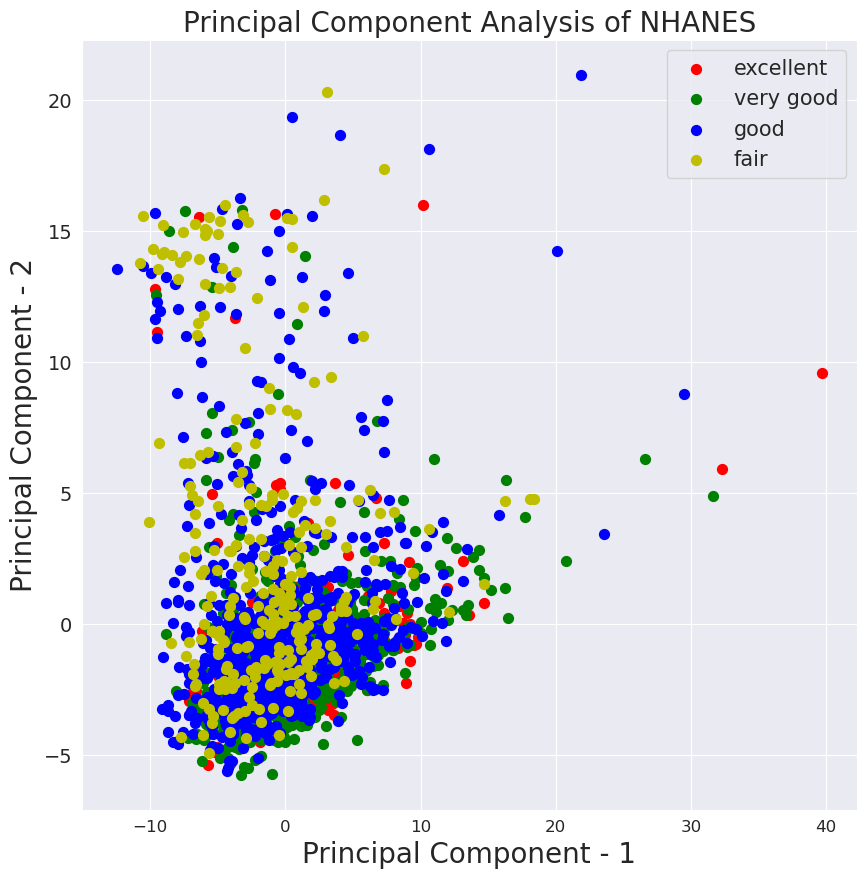

In [11]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
# figure settings
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of NHANES",fontsize=20)
targets = ['excellent', 'very good', 'good', 'fair', 'poor']
colors = ['r', 'g', 'b', 'y']
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
hsd010 = hsd010.replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
for target, color in zip(targets,colors):
    indicesToKeep = hsd010 == target
    indicesToKeep = indicesToKeep.reset_index(drop=True) #had to add this line
    plt.scatter(pca_df.loc[indicesToKeep, 'principal component 1']
               , pca_df.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)
# show figure
plt.legend(targets,prop={'size': 15})
plt.show();

**When analyzing the scatterplot of the first two components, it is unclear whether the data follow a pattern or specific grouping. This helps me understand that it is probably a good decisions to use three PCA components to better capture underlying patterns (which makes sense given the cumulative variance plot - the first two components only explain 80% of the total variation in the data).** 

## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

**I chose to use a K-means clustering algorithm because it is the most straightforward and may be most helpful in this case where there are clearly 3 main principal components.**

### Cluster nhanes

In [12]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
#nhanes_scaled.head()

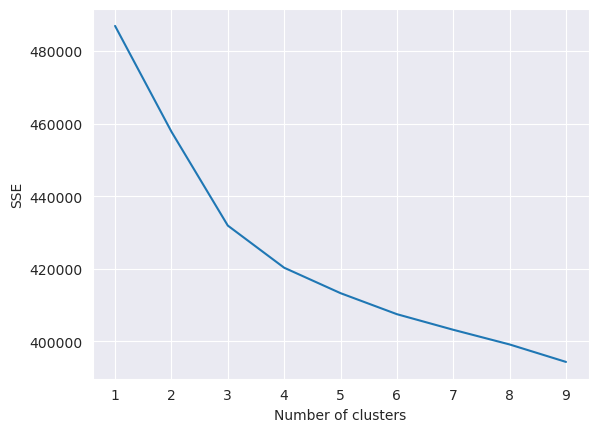

In [13]:
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(nhanes_scaled)
    nhanes_scaled["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()

**Based on the above scree plot, three or four clusters seems to be the best choice for these data as that's when the reduction in the sum of squared errors starts to slow dramatically (hence the bend or "elbow" in the lineplot). I chose to stick with three because that's when the slope of the line starts decreasign at a dramatically decreasing rate, so it is less worth it to pursure more than that number of clusters to reduce overall error.**

### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

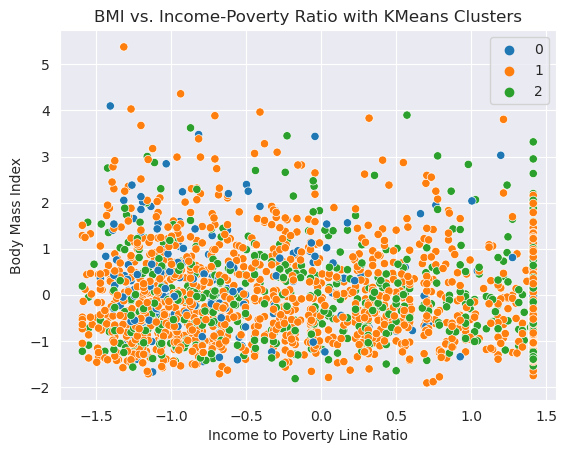

In [14]:
kmeans = KMeans(n_clusters=3, n_init=10, max_iter=300, random_state=42)
labels = kmeans.fit_predict(nhanes_scaled)

# Create a scatter plot for BMI vs. Income-Poverty Ratio
ax = sns.scatterplot(x="INDFMPIR", y="BMXBMI", hue=labels, palette="tab10", data=nhanes_scaled)

# Set axis labels and title
ax.set(xlabel="Income to Poverty Line Ratio", ylabel="Body Mass Index")
ax.set_title("BMI vs. Income-Poverty Ratio with KMeans Clusters")

# Display the plot
plt.show()

**It is hard to distinguish clear clusters in this plot as all three clusters are mixed in with each other (no clear boundaries).**

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

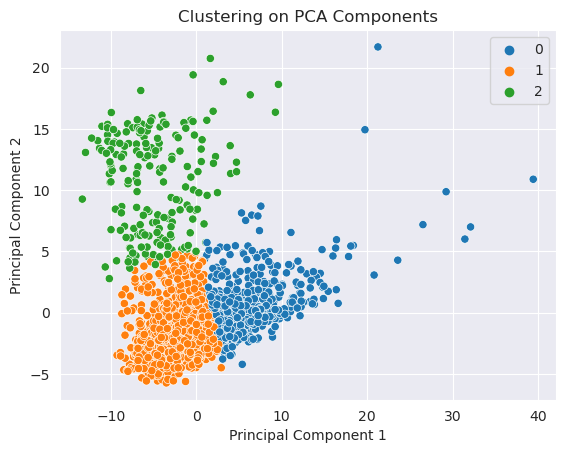

In [15]:
# Perform PCA to double check
pca = PCA(n_components=3)
pca_components = pca.fit_transform(nhanes_scaled)

# Retrain KMeans on PCA components
kmeans_pca = KMeans(n_clusters=3, n_init=10, max_iter=300, random_state=42)
labels_pca = kmeans_pca.fit_predict(pca_components)

# Create a scatter plot for the first two principal components
ax = sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=labels_pca, palette="tab10")

# Set axis labels and title
ax.set(xlabel="Principal Component 1", ylabel="Principal Component 2")
ax.set_title("Clustering on PCA Components")

# Display the plot
plt.show()

**Now there are much clearer clusters and boundaries after using the PCA components as inputs to my kmeans algorithm; this means that the PCA operation is likely accurately capturing most of the cluster differences and may yield decent prediction/classification results.**

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [16]:
# partition data

y = nhanes_scaled['HSD010'] # either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already 
X = nhanes_scaled.drop(['HSD010'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

In [17]:
# load libraries
# -----------
import keras
from keras.utils import to_categorical

num_classes = 10
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, 
                                     num_classes)
y_test = keras.utils.to_categorical(y_test, 
                                    num_classes)
num_classes = y_test.shape[1]

In [18]:
# ----------
in_dim = X_train.shape[1]
in_dim

242

In [19]:
# create neural network model
# -----------
model = Sequential()

model.add(Dense(in_dim, input_dim=in_dim, kernel_initializer= 'normal', activation= 'relu'))

model.add(Dense(num_classes, kernel_initializer= 'normal', activation= 'softmax'))

## Add any additional layers you wish here

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)

Epoch 1/10


2023-12-15 07:49:48.804931: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-12-15 07:49:48.804956: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-12-15 07:49:48.804973: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-sofiaguo): /proc/driver/nvidia/version does not exist
2023-12-15 07:49:48.805298: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


8/8 - 1s - loss: 1.9866 - accuracy: 0.3236 - val_loss: 1.6300 - val_accuracy: 0.4205 - 735ms/epoch - 92ms/step
Epoch 2/10
8/8 - 0s - loss: 1.4081 - accuracy: 0.4864 - val_loss: 1.3720 - val_accuracy: 0.4496 - 48ms/epoch - 6ms/step
Epoch 3/10
8/8 - 0s - loss: 1.1925 - accuracy: 0.5349 - val_loss: 1.2827 - val_accuracy: 0.4516 - 45ms/epoch - 6ms/step
Epoch 4/10
8/8 - 0s - loss: 1.0863 - accuracy: 0.5620 - val_loss: 1.2425 - val_accuracy: 0.4651 - 46ms/epoch - 6ms/step
Epoch 5/10
8/8 - 0s - loss: 1.0094 - accuracy: 0.6072 - val_loss: 1.2238 - val_accuracy: 0.4593 - 47ms/epoch - 6ms/step
Epoch 6/10
8/8 - 0s - loss: 0.9458 - accuracy: 0.6344 - val_loss: 1.2080 - val_accuracy: 0.4651 - 46ms/epoch - 6ms/step
Epoch 7/10
8/8 - 0s - loss: 0.8940 - accuracy: 0.6563 - val_loss: 1.2063 - val_accuracy: 0.4651 - 47ms/epoch - 6ms/step
Epoch 8/10
8/8 - 0s - loss: 0.8437 - accuracy: 0.6893 - val_loss: 1.2069 - val_accuracy: 0.4554 - 48ms/epoch - 6ms/step
Epoch 9/10
8/8 - 0s - loss: 0.7979 - accuracy: 0.

### Neural Network on Principal Components

In [20]:
pca_df

,principal component 1,principal component 2,principal component 3
0,9.527811,-0.816227,-1.867118
1,-5.838338,-3.692571,3.805765
2,-0.719454,-2.573203,0.907907
3,3.533627,-2.576977,-3.249086
4,-6.872094,-4.194242,0.886868
...,...,...,...
2059,2.643319,-1.689357,-0.702572
2060,1.037906,-0.118066,5.556515
2061,1.130254,-0.970433,3.415322
2062,7.145093,-0.376758,1.753469


In [21]:
# partition data of PCA

y = nhanes_scaled['HSD010'] # either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already 
X = pca_df

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

In [22]:
# load libraries
# -----------
import keras
from keras.utils import to_categorical

num_classes = 10
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, 
                                     num_classes)
y_test = keras.utils.to_categorical(y_test, 
                                    num_classes)
num_classes = y_test.shape[1]

In [23]:
# ----------
in_dim = X_train.shape[1]
in_dim

3

In [24]:
# create neural network model
# -----------
model = Sequential()

model.add(Dense(in_dim, input_dim=in_dim, kernel_initializer= 'normal', activation= 'relu'))

model.add(Dense(num_classes, kernel_initializer= 'normal', activation= 'softmax'))

## Add any additional layers you wish here

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)

Epoch 1/10
8/8 - 1s - loss: 2.2948 - accuracy: 0.1964 - val_loss: 2.2876 - val_accuracy: 0.2500 - 584ms/epoch - 73ms/step
Epoch 2/10
8/8 - 0s - loss: 2.2812 - accuracy: 0.2758 - val_loss: 2.2736 - val_accuracy: 0.3062 - 37ms/epoch - 5ms/step
Epoch 3/10
8/8 - 0s - loss: 2.2665 - accuracy: 0.3120 - val_loss: 2.2584 - val_accuracy: 0.3353 - 36ms/epoch - 4ms/step
Epoch 4/10
8/8 - 0s - loss: 2.2505 - accuracy: 0.3340 - val_loss: 2.2418 - val_accuracy: 0.3488 - 36ms/epoch - 5ms/step
Epoch 5/10
8/8 - 0s - loss: 2.2329 - accuracy: 0.3443 - val_loss: 2.2237 - val_accuracy: 0.3663 - 38ms/epoch - 5ms/step
Epoch 6/10
8/8 - 0s - loss: 2.2137 - accuracy: 0.3585 - val_loss: 2.2040 - val_accuracy: 0.3721 - 37ms/epoch - 5ms/step
Epoch 7/10
8/8 - 0s - loss: 2.1929 - accuracy: 0.3702 - val_loss: 2.1828 - val_accuracy: 0.3837 - 37ms/epoch - 5ms/step
Epoch 8/10
8/8 - 0s - loss: 2.1704 - accuracy: 0.3760 - val_loss: 2.1603 - val_accuracy: 0.3915 - 36ms/epoch - 5ms/step
Epoch 9/10
8/8 - 0s - loss: 2.1469 - a

### Neural Network on Principal Components + Cluster Membership

In [25]:
#add the labels to the pca_df
pca_df['kmeans']= labels_pca

In [26]:
# partition data of PCA + kmeans cluster labels

y = nhanes_scaled['HSD010'] # either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already 
X = pca_df

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

In [27]:
# load libraries
# -----------
import keras
from keras.utils import to_categorical

num_classes = 10
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, 
                                     num_classes)
y_test = keras.utils.to_categorical(y_test, 
                                    num_classes)
num_classes = y_test.shape[1]

In [28]:
# ----------
in_dim = X_train.shape[1]
in_dim

4

In [29]:
# create neural network model
# -----------
model = Sequential()

model.add(Dense(in_dim, input_dim=in_dim, kernel_initializer= 'normal', activation= 'relu'))

model.add(Dense(num_classes, kernel_initializer= 'normal', activation= 'softmax'))

## Add any additional layers you wish here

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)

Epoch 1/10
8/8 - 1s - loss: 2.3036 - accuracy: 0.0769 - val_loss: 2.2931 - val_accuracy: 0.1395 - 583ms/epoch - 73ms/step
Epoch 2/10
8/8 - 0s - loss: 2.2874 - accuracy: 0.1738 - val_loss: 2.2772 - val_accuracy: 0.2093 - 37ms/epoch - 5ms/step
Epoch 3/10
8/8 - 0s - loss: 2.2711 - accuracy: 0.2267 - val_loss: 2.2607 - val_accuracy: 0.2810 - 39ms/epoch - 5ms/step
Epoch 4/10
8/8 - 0s - loss: 2.2541 - accuracy: 0.2539 - val_loss: 2.2431 - val_accuracy: 0.3081 - 41ms/epoch - 5ms/step
Epoch 5/10
8/8 - 0s - loss: 2.2356 - accuracy: 0.3081 - val_loss: 2.2240 - val_accuracy: 0.3527 - 36ms/epoch - 5ms/step
Epoch 6/10
8/8 - 0s - loss: 2.2153 - accuracy: 0.3165 - val_loss: 2.2028 - val_accuracy: 0.3624 - 37ms/epoch - 5ms/step
Epoch 7/10
8/8 - 0s - loss: 2.1931 - accuracy: 0.3230 - val_loss: 2.1791 - val_accuracy: 0.3682 - 37ms/epoch - 5ms/step
Epoch 8/10
8/8 - 0s - loss: 2.1682 - accuracy: 0.3320 - val_loss: 2.1530 - val_accuracy: 0.3779 - 37ms/epoch - 5ms/step
Epoch 9/10
8/8 - 0s - loss: 2.1410 - a

## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

**PCA focuses on constructing composite features which are combinations of the original features which are numerous and strongly correlated with each other, while clustering focuses on categorizing features into similar groups via their distance to a certain centroid or average value. PCA doesn't necessarily have to reduce features that would otherwise be placed in the same cluster.**

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

**In terms of advantages in clustering methods, using PCA generated features created very clear boundaries of clusters because by definition, PCA creates composite variables that are uncorrelated to each other which makes them perfect inputs for a clustering algorithm that depends on labels being very different. However, I did not find that a neural net trained on the cluster labels of PCA inputs (max accuracy of 40 percent) did better than a neural net trained on the original data (max accuracy of 73 percent) or even a NN trained on PCA components alone (max accuracy of 41 percent). This is probably because the selection of three PCA components left out enough explanatory features so that the model trained on the full set of features still captures more components than PCA.**

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"

**When working with big data, it may be helpful to learn more about the ways features are correlated with each other and reduce unnecesary multicolinearity that may bias the predictions of a model, in combination with using clustering to help distinguish categories and labels of data that may otherwise be too noisy to distinguish clear labels from.**